In [1]:
%%capture
!pip install imutils
!pip install wget
!pip install split-folders
!pip install timm
!pip install pytorch-lightning
!pip install torchmetrics
!pip install rich

In [2]:
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import splitfolders
from torch import nn
import numpy as np
import os
import torchmetrics
import timm
import wget
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import cv2
import tensorflow as tf
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

2022-05-19 13:49:16.534258: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Downloading Dataset

In [3]:
_URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
wget.download(_URL)

'flickr_logos_27_dataset.tar.gz'

In [4]:
!ls

__notebook_source__.ipynb  flickr_logos_27_dataset.tar.gz


In [5]:
zip_dir = tf.keras.utils.get_file('./logo', origin=_URL, untar=True,extract=True)

101834752/101827904 [==============================] - 11s 0us/step


In [6]:
import tarfile

fname = 'flickr_logos_27_dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [7]:
fname = 'flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [8]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

## Preprocessing

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep='\s+',header=None)

In [11]:
df

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [12]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [13]:
dtdir = './flickr_logos_27_dataset_images/'

In [14]:
im = df[0][0]

In [15]:
size = df.iloc[:,3:]

In [16]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [17]:
img = os.path.join(dtdir,im)

In [18]:
size = size.values.tolist()

In [19]:
size[0][0],size[0][1],size[0][2],size[0][3]

(38, 12, 234, 142)

(210, 280, 3)

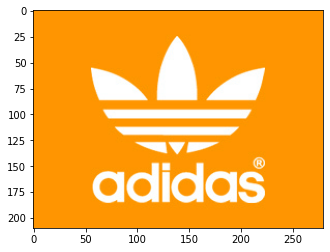

In [20]:
image = cv2.imread(img)
plt.imshow(image)
image.shape

(130, 196, 3)

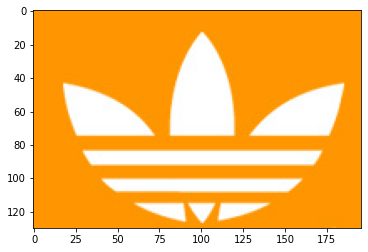

In [21]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
plt.imshow(image)
image.shape

In [22]:
query = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [23]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


(500, 437, 3)

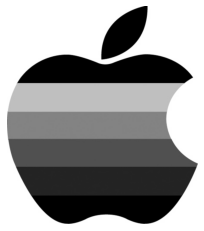

In [24]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
plt.imshow(image)
plt.axis("off")
image.shape

In [25]:
y = list(set(list(Y)))
y.sort()

In [26]:
for i in y:
    os.makedirs(os.path.join(dest,i))

In [27]:
distractor = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [28]:
distractor

,0
0,http://farm2.static.flickr.com/1184/1013364004...
1,http://farm2.static.flickr.com/1108/1047095104...
2,http://farm2.static.flickr.com/1359/1076885577...
3,http://farm1.static.flickr.com/53/110432189_6d...
4,http://farm2.static.flickr.com/1144/1153048029...
...,...
4202,http://farm2.static.flickr.com/1254/889763557_...
4203,http://farm2.static.flickr.com/1308/901063602_...
4204,http://farm1.static.flickr.com/18/93551127_fed...
4205,http://farm2.static.flickr.com/1033/978252884_...


In [29]:
HEIGHT = 224
WIDTH =  224
BS = 64

## Removing Corrupt Images 

In [30]:
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass

error
error
error
error
error


In [31]:
A = query.iloc[:,0]
B = query.iloc[:,1]

In [32]:
A

0      2403695909.jpg
1      2912587920.jpg
2      3441398196.jpg
3      4605630935.jpg
4      4606245138.jpg
            ...      
265    3480640208.jpg
266    3486224308.jpg
267    3486430785.jpg
268    3490185235.jpg
269    3490913574.jpg
Name: 0, Length: 270, dtype: object

In [33]:

for i in range(len(A)):
    try:
        destrain = os.path.join(dest,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [34]:
imagePaths = list(paths.list_images(dest))

LOGOS/Unicef/3654131280.jpg


(224, 224, 3)

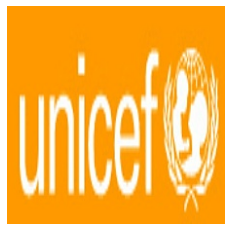

In [35]:
img = imagePaths[40]
print(img)
image = cv2.imread(img)
plt.imshow(image)
plt.axis("off")
image.shape

## Train Val Split

In [36]:
path = 'LOGOS'

In [37]:
splitfolders.ratio(path, output="data", seed=42, ratio=(0.8,0.2))

Copying files: 944 files [00:00, 7682.52 files/s]


## Image Augmentation

In [38]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(WIDTH,HEIGHT))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)
coljtr = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)
raf = transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0)
rrsc = transforms.RandomResizedCrop(size=WIDTH, scale=(0.8, 1.0))
ccp  = transforms.CenterCrop(size=WIDTH)  # Image net standards
nrml = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])  # Imagenet standards

In [39]:
# initialize our training and validation set data augmentation
# pipeline
trainTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])
valTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])

In [40]:
# initialize the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root='./data/train',transform=trainTransforms)
valDataset = ImageFolder(root='./data/val', transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(len(valDataset)))

[INFO] loading the training and validation dataset...
[INFO] training dataset contains 755 samples...
[INFO] validation dataset contains 189 samples...


In [62]:
class LitNeuralNet(pl.LightningModule):
    def __init__(self,num_classes):
        super(LitNeuralNet, self).__init__()
        
        
        self.model = timm.create_model('efficientnet_b0', pretrained=True)
        self.model.aux_logits=False

        # Freeze training for all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.classifier = nn.Sequential(
                      nn.Linear(self.model.classifier.in_features, 256), 
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True),
                      nn.BatchNorm1d(256),
                      nn.Linear(256, num_classes),
                      nn.LogSoftmax(dim=1))
        # add metrics
        self.train_acc = torchmetrics.Accuracy()
        self.train_f1 = torchmetrics.F1(average="micro")
        self.val_acc = torchmetrics.Accuracy()
        self.val_f1 = torchmetrics.F1(average="micro")
        
    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.forward(images)
        lossfn = nn.NLLLoss()
        loss = lossfn(outputs, labels)
        
        y_pred = torch.exp(outputs)
        #y_pred = output.data.max(1, keepdim=True)[1]
        acc = self.train_acc(y_pred, labels)
        f1 = self.train_f1(y_pred, labels)
        # just accumulate

        self.log("train_loss", loss)
        self.log("train_accuracy", acc)
        self.log("train_f1", f1)
        tensorboard_logs = {'train_loss': loss}
        # use key 'log'
        return {"loss": loss, 'log': tensorboard_logs}

    # define what happens for testing here

    def train_dataloader(self):
        trainDataLoader = DataLoader(trainDataset, num_workers=2,batch_size=BS, shuffle=True)

        return trainDataLoader

    def val_dataloader(self):
        valDataLoader = DataLoader(valDataset, num_workers=2,batch_size=BS,shuffle=False)
        
        return valDataLoader
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.forward(images)
        lossfn = nn.NLLLoss()   
        loss = lossfn(outputs, labels)
        
        pred = torch.exp(outputs)
        #pred = output.data.max(1, keepdim=True)[1]
        self.val_acc.update(pred, labels)
        self.val_f1.update(pred, labels)

        self.log("val_loss", loss)
        return {"val_loss": loss}
    
    def training_epoch_end(self, training_step_outputs):
        # compute metrics
        train_accuracy = self.train_acc.compute()
        train_f1 = self.train_f1.compute()
        # log metrics
        self.log("epoch_train_accuracy", train_accuracy)
        self.log("epoch_train_f1", train_f1)
        # reset all metrics
        self.train_acc.reset()
        self.train_f1.reset()
        print(f"\ntraining accuracy: {train_accuracy:.4}, "\
        f"f1: {train_f1:.4}")
        
    def validation_epoch_end(self, outputs):
        # outputs = list of dictionaries
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_accuracy = self.val_acc.compute()
        val_f1 = self.val_f1.compute()
        # log metrics
        self.log("val_accuracy", val_accuracy)
        self.log("val_loss", avg_loss)
        self.log("val_f1", val_f1)
        # reset all metrics
        self.val_acc.reset()
        self.val_f1.reset()
        print(f"\nvalidation accuracy: {val_accuracy:.4} "\
        f"f1: {val_f1:.4}")
        
        tensorboard_logs = {'avg_val_loss': avg_loss}
        # use key 'log'
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters())


In [63]:
# seeding for torch, numpy, stdlib random, including DataLoader workers!
seed_everything(123, workers=True)

early_stopping = EarlyStopping(
    monitor="val_loss",
    stopping_threshold=1e-5,
    divergence_threshold=9.0,
    check_finite=True)

In [64]:
from pytorch_lightning.loggers import WandbLogger

In [65]:
wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')

In [66]:
model = LitNeuralNet(num_classes=len(trainDataset.classes))
trainer = Trainer(accelerator='gpu', devices=1,max_epochs=100,log_every_n_steps=8,callbacks=[early_stopping])
trainer.fit(model)

Validation sanity check: 0it [00:00, ?it/s]


validation accuracy: 0.02344 f1: 0.02344


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]


validation accuracy: 0.4762 f1: 0.4762

training accuracy: 0.1391, f1: 0.1391


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.5767 f1: 0.5767

training accuracy: 0.4119, f1: 0.4119


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.6402 f1: 0.6402

training accuracy: 0.5457, f1: 0.5457


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.6455 f1: 0.6455

training accuracy: 0.5974, f1: 0.5974


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.6878 f1: 0.6878

training accuracy: 0.6358, f1: 0.6358


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.6931 f1: 0.6931

training accuracy: 0.657, f1: 0.657


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.6931 f1: 0.6931

training accuracy: 0.6993, f1: 0.6993


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.6984 f1: 0.6984

training accuracy: 0.7152, f1: 0.7152


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.7143 f1: 0.7143

training accuracy: 0.7444, f1: 0.7444


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.7196 f1: 0.7196

training accuracy: 0.7338, f1: 0.7338


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.7249 f1: 0.7249

training accuracy: 0.7656, f1: 0.7656


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.7249 f1: 0.7249

training accuracy: 0.7377, f1: 0.7377


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.746 f1: 0.746

training accuracy: 0.7722, f1: 0.7722


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.709 f1: 0.709

training accuracy: 0.7947, f1: 0.7947


Validating: 0it [00:00, ?it/s]


validation accuracy: 0.7407 f1: 0.7407

training accuracy: 0.7907, f1: 0.7907


## Prediction On Test Images

In [67]:
testimage = list(paths.list_images('./flickr_logos_27_dataset_images'))

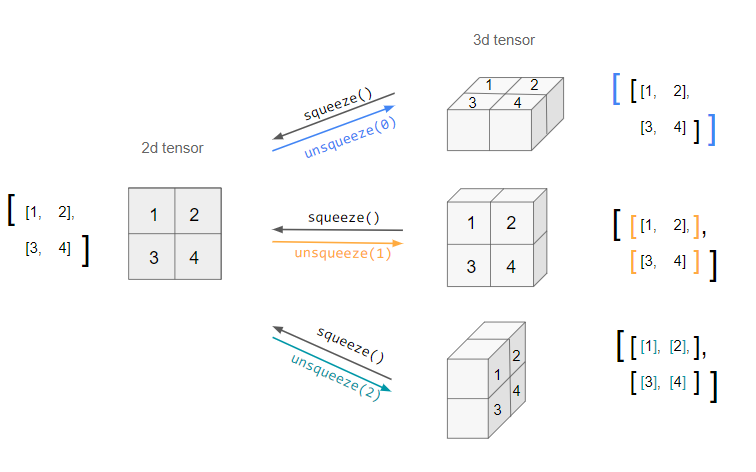

In [68]:
def predimg(path):
    from PIL import Image
    image = Image.open(path)
    plt.imshow(image)
    plt.axis("off")
    plt.show() 
    model.eval()
    with torch.no_grad():
      img =  load_img(path)
      mean = [0.485, 0.456, 0.406] 
      std = [0.229, 0.224, 0.225]
      transform_norm = transforms.Compose([transforms.ToTensor(), 
      transforms.Resize((224,224)),transforms.Normalize(mean, std)])
      img_normalized = transform_norm(img).float()
      img_normalized = img_normalized.unsqueeze(0)
      img = torch.from_numpy(np.asarray(img)).permute(2, 0, 1)
      img = img_normalized#.to(device)
      img = DataLoader(img, num_workers=4,batch_size=BS,shuffle=False)
      output = trainer.predict(model,img)
      output = torch.exp(output[0][0])
      #print(output)
      index = output.data.cpu().numpy().argmax()
      result = list(np.around(output.data.cpu().numpy()*100,1))
      print(result)
      print("PREDICTED CLASS = ",trainDataset.classes[index])

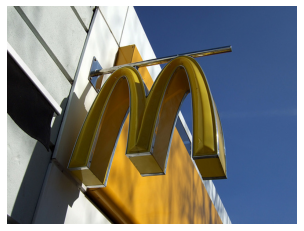

Predicting: 12it [00:00, ?it/s]

[5.2, 0.5, 1.1, 3.0, 1.5, 3.5, 2.4, 1.9, 0.8, 0.8, 2.5, 7.7, 0.5, 30.3, 0.6, 4.4, 3.0, 0.7, 5.5, 1.1, 3.5, 2.9, 2.8, 4.9, 7.1, 0.6, 1.4]
PREDICTED CLASS =  McDonalds


In [69]:
predimg(testimage[8])

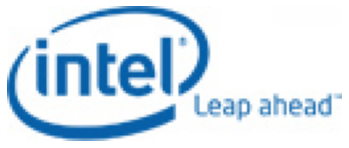

Predicting: 12it [00:00, ?it/s]

[0.1, 0.3, 0.3, 0.1, 0.3, 0.1, 0.3, 0.5, 2.9, 5.1, 4.3, 0.1, 73.3, 0.2, 1.5, 0.2, 0.1, 0.8, 0.0, 0.6, 0.5, 1.4, 1.5, 0.1, 3.7, 0.9, 0.6]
PREDICTED CLASS =  Intel


In [75]:
predimg(testimage[40])

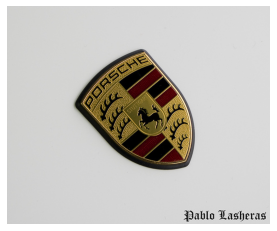

Predicting: 12it [00:00, ?it/s]

[0.2, 0.2, 0.8, 0.3, 1.7, 2.2, 0.3, 1.8, 5.1, 0.3, 0.3, 1.0, 0.6, 1.7, 1.3, 0.3, 0.4, 0.6, 74.1, 0.1, 2.3, 0.4, 1.0, 1.2, 1.4, 0.3, 0.2]
PREDICTED CLASS =  Porsche


In [71]:
predimg(testimage[16])

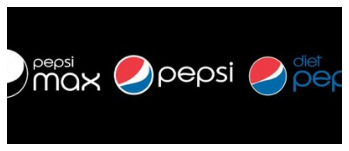

Predicting: 12it [00:00, ?it/s]

[6.1, 4.3, 3.8, 0.4, 2.4, 1.7, 1.3, 0.1, 1.2, 1.9, 1.4, 0.6, 3.4, 1.6, 1.1, 8.4, 2.1, 39.4, 0.4, 0.8, 3.6, 1.5, 1.5, 0.7, 5.2, 3.6, 1.2]
PREDICTED CLASS =  Pepsi


In [83]:
predimg(testimage[88])

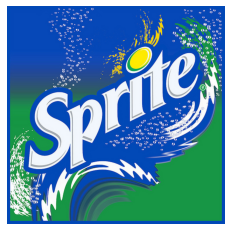

Predicting: 12it [00:00, ?it/s]

[0.0, 0.0, 0.0, 0.1, 0.4, 0.1, 0.0, 0.7, 0.5, 0.2, 0.1, 0.7, 0.3, 0.6, 0.0, 1.8, 0.0, 0.1, 0.1, 0.1, 1.0, 90.8, 0.7, 0.3, 1.1, 0.1, 0.1]
PREDICTED CLASS =  Sprite


In [85]:
predimg(testimage[100])